# import libraries

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import collections

In [70]:
def RMSE(y_true, y_pred):
    return np.linalg.norm(y_true - y_pred) / np.sqrt(len(y_true))

In [71]:
def MakeBoxplot(y_true, y_pred, title):
    data = [y_pred[y_true == (x*0.5+0.5)] for x in range(10)]
    fig = plt.figure(figsize=(5, 5))
    plt.boxplot(data)
    min_a, max_a = 0., 5.5
    plt.xlim((min_a, max_a))
    plt.ylim((min_a, max_a))
    plt.plot([min_a, max_a * 2], [min_a, max_a], ls='--', color='gray', linewidth=1.0)
    plt.xticks(range(12), [x*0.5 for x in range(12)])
    plt.xlabel('True Rating')
    plt.ylabel('Predicted Rating')
    plt.title(title)
    plt.show()

# Read data

In [72]:
review = pd.read_csv('/content/olist_order_reviews_dataset.csv')
items = pd.read_csv('/content/olist_order_items_dataset.csv')
dataset = pd.read_csv('/content/olist_orders_dataset.csv')
costumer = pd.read_csv('/content/olist_customers_dataset.csv')

merged_data1 = review.merge(items,on="order_id")
merged_final1 = dataset.merge(merged_data1 , on="order_id")
merged_final = merged_final1.merge(costumer,on = "customer_id")
merged_final.dropna()
merged_final.head()

order_id  ... customer_state
0  e481f51cbdc54678b7cc49136f2d6af7  ...             SP
1  53cdb2fc8bc7dce0b6741e2150273451  ...             BA
2  47770eb9100c2d0c44946d9cf07ec65d  ...             GO
3  949d5b44dbf5de918fe9c16f97b45f8a  ...             RN
4  ad21c59c0840e6cb83a9ceb5573f8159  ...             SP

[5 rows x 24 columns]

# get only the needed data

In [73]:
needed_data = merged_final[['customer_unique_id','product_id','review_score']]
needed_data = needed_data.dropna()
needed_data.head()

customer_unique_id  ... review_score
0  7c396fd4830fd04220f754e42b4e5bff  ...            4
1  af07308b275d755c9edb36a90c618231  ...            4
2  3a653a41f6f9fc3d2a113cf8398680e8  ...            5
3  7c142cf63193a1473d2e66489a9ae977  ...            5
4  72632f0f9dd73dfee390c9b22eb56dd6  ...            5

[5 rows x 3 columns]

# select the users with more than one order (obligation )

In [74]:
users = list(needed_data['customer_unique_id'])
users_to_save = []
print(len(users),len(list(needed_data['customer_unique_id'])))
'''
for user in users : 
  d = needed_data[needed_data['customer_id']==user]
  if d.shape[0]>1:
    users_to_save.append(user)
'''



counter=collections.Counter(users)
counter

for user in counter.keys():
  if counter[user]>1:
    users_to_save.append(user)
    
final_data = needed_data[needed_data['customer_unique_id'].isin(users_to_save)]
final_data.head()

113322 113322


customer_unique_id  ... review_score
0   7c396fd4830fd04220f754e42b4e5bff  ...            4
10  f2a85dec752b8517b5e58a06ff3cd937  ...            1
11  f2a85dec752b8517b5e58a06ff3cd937  ...            1
16  ccafc1c3f270410521c3c6f3b249870f  ...            5
17  6e26bbeaa107ec34112c64e1ee31c0f5  ...            4

[5 rows x 3 columns]

#split data into train and test

In [75]:
df_train , df_test = train_test_split(final_data , test_size = 0.5 , stratify = final_data.customer_unique_id)

# remove product from test that doesn't exist in train

In [76]:
df_test_to_remove = df_test[~df_test['product_id'].isin(df_train['product_id'].unique())]
df_test = df_test[~df_test.apply(tuple,1).isin(df_test_to_remove.apply(tuple,1))]

# rename columns (optional)

In [77]:

df_train.columns = ['customer_id','product_id','review_score']
df_test.columns = ['customer_id','product_id','review_score']

In [78]:
y_true = df_test['review_score'].values

# global mean

global_mean = 3.6616632044495074
RMSE = 1.6035327387906528


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


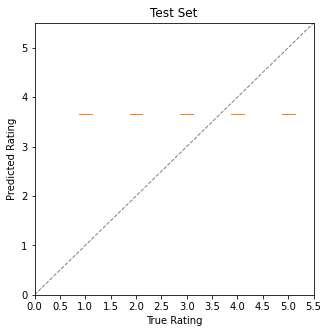

In [79]:
# global mean
global_mean = df_train['review_score'].mean()
print("global_mean =", global_mean)
# prediction
y_pred = []
for i, row in df_test.iterrows():
    y_pred.append(global_mean)
y_pred = np.array(y_pred)
y_pred = np.clip(y_pred, 0.5, 5.0)
# or simply y_pred = np.array([global_mean for i in range(len(y_true))])
# performance
error = RMSE(y_true, y_pred)
print("RMSE =", error)
MakeBoxplot(y_true, y_pred, 'Test Set')

#user mean

RMSE = 0.5700444556592537


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


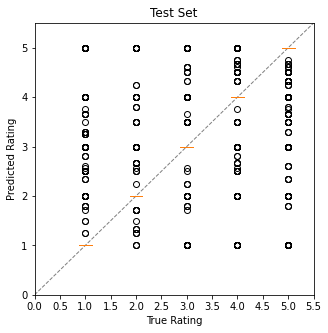

In [80]:
# user mean
user_mean = df_train.groupby('customer_id')['review_score'].mean()
# prediction
y_pred = []
for i, row in df_test.iterrows():
    y_pred.append(user_mean[row['customer_id']])
y_pred = np.array(y_pred)
y_pred = np.clip(y_pred, 0.5, 5.0)
# performance
error = RMSE(y_true, y_pred)
print("RMSE =", error)
MakeBoxplot(y_true, y_pred, 'Test Set')

#item mean

RMSE = 1.2938142984143806


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


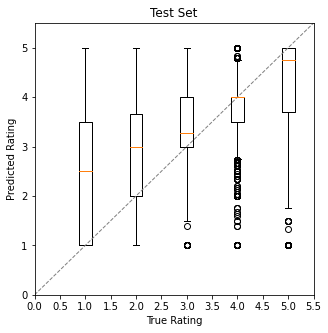

In [81]:
# movie mean
movie_mean = df_train.groupby('product_id')['review_score'].mean()
# prediction
y_pred = []
for i, row in df_test.iterrows():
    y_pred.append(movie_mean[row['product_id']])
y_pred = np.array(y_pred)
y_pred = np.clip(y_pred, 0.5, 5.0)
# performance
error = RMSE(y_true, y_pred)
print("RMSE =", error)
MakeBoxplot(y_true, y_pred, 'Test Set')

#combined

RMSE = 0.8071649573085725


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


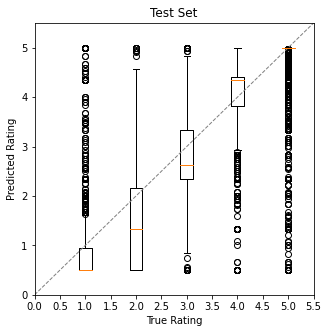

In [82]:
# Combined model
# prediction
y_pred = []
for i, row in df_test.iterrows():
    r = user_mean[row['customer_id']] + movie_mean[row['product_id']] - global_mean
    y_pred.append(r)
y_pred = np.array(y_pred)
y_pred = np.clip(y_pred, 0.5, 5.0)
# performance
error = RMSE(y_true, y_pred)
print("RMSE =", error)
MakeBoxplot(y_true, y_pred, 'Test Set')